# Term Project Proposal
2015102737 산업경영공학과 오승영

> 2019년도 2학기 경희대 웹파이썬 수업 개인 텀 프로젝트 문서입니다

# 0. 주제
회귀분석을 활용한 서울시 시위 규모 분석

# 1. 주제 선정 이유
시위 규모는 정치적으로 중요한 사안이다. 미디어에서는 이번 시위 규모를 측정하고 발표한다. 정치인들은 이를 인용하며 민심을 파악하고자 노력한다.
이념을 넘어서 현실 사회에서도 시위 규모를 파악하는 일은 중요하다. 시위 규모가 커지면 교통 마비 현상이 일어날 수 있다. 또한 규모에 따라 경찰 인원을 결정해 투입해야 하는 등 행정 절차가 요구되기 때문이다.


# 2. 가설 정의
시위 참여는 민심의 대변이다. 정치 이슈에 따라 시시각각 변하는 민심을 데이터로 정량화해서 집회 신고 인원수에 미치는 영향을 확인하고자 한다.  웹상에서 정치 이슈에 대한 유저들의 댓글, 반응 등을 크롤링해 정량화한 데이터로 분석을 해볼 계획이다. 
서울 지방 경찰청 오늘의 집회/시위 게시판에는 서울시 주요 집회 신고 인원이 일별로 올라와 있다. 이 데이터를 종속 변수로 두고 각각 독립변수들이 주는 영향을 분석한다. tensorflow 라이브러리로 다중 선형 회귀분석을 실시한다. 유의미한 영향을 줄 수 있다고 예상되는 독립 변수로는 "날씨", "네이버 정치 기사 좋아요/싫어요 수", "네이버 정치 기사 댓글 수"가 있다.

# 3. 인터넷을 통한 데이터 획득
* 3. 과 4. 의 코드는 주피터에서 실행이 불가한 코드입니다.

### 1) 이미지 크롤링
서울지방경찰청 사이트으로부터 일일 시위 신고수를 집계한 이미지들을 크롤링했다.
(https://www.smpa.go.kr/home/homeIndex.do?menuCode=www)

In [ ]:
from selenium import webdriver as wd
import time
startPage = 1
endPage = 10

for p in range(startPage, endPage+1):
    driver  = wd.Chrome(executable_path = './chromedriver')
    url = "https://www.smpa.go.kr/user/nd54882.do?page="+str(p)+"&pageLS=&pageSC=SORT_ORDER&pageSO=DESC&pageST=SUBJECT&pageSV=&itemShCd1=&itemShCd2=&itemShCd3="
    driver.get(url)
    driver.implicitly_wait(5)
    print(p, "번째 page 접속 성공")
    driver.implicitly_wait(5)

    #time.sleep(5)
    for i in range(1,11):
        postPath = "/html/body/form/div/div[2]/div[3]/table/tbody/tr[" + str(i) +"]/td[2]/a"
        driver.find_element_by_xpath(postPath).click()
        print(p,"페이지 ", i,"번 째 post 접속 성공!")
        driver.implicitly_wait(5)
        fileNames = driver.find_elements_by_class_name('doc_link')
        for j in range(0,len(fileNames)):
            if "jpg" in fileNames[j].text:    
                imgPath = "/html/body/form/div/div[2]/div[3]/table/tbody/tr[3]/td/a["+str(j+1)+ "]"
                #xpath 는 1부터 idx 시작
                driver.find_element_by_xpath(imgPath).click()
                driver.implicitly_wait(5)
        driver.back() #목록으로
        driver.back() #목록으로        
        print(p,"페이지 ",i,"번 째 post 다운로드 완료!")
    driver.close()



### 2) 정치 뉴스 "화나요" 크롤링
네이버 정치 랭킹 뉴스들을 일자별로 모두 들어가서 "화나요" 수를 크롤링했다.
일일 약 30개 정도의 뉴스를 동적으로 크롤링해야 했기 때문에 시간이 많이 걸렸다.
뒤늦게 selenium에서 옵션을 줘서 필요 없는 정보들(이미지, 동영상 등등)을 로딩하지 않을 수 있는 방법을 찾아서
이를 적용했다.

https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=100&date=20190805

In [ ]:
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import bs4
import urllib.request
import time
import datetime
import configparser
import os

config = configparser.ConfigParser()
config.read(os.path.dirname(os.path.realpath(__file__)) + os.sep + 'envs' + os.sep + 'propertyNews.ini')

class NewsParser:
    def __init__(self, startUrl):
        self.startUrl = startUrl
        self.topUrlList = []
        self.cntHateList = []

    #brief: Parse top news using BeautifulSoup
    #post: append top newsUrls
    def ParseTopByBs(self):
        print("top url 접속")
        html = urllib.request.urlopen(self.startUrl)
        bsHtml = bs4.BeautifulSoup(html, "html.parser")
        topUrls = (bsHtml.findAll("div", {"class":"ranking_thumb"}))
        for i in topUrls:
            tempStr = str(i)
            tempList = tempStr.split('"')
            newsUrl = "https://news.naver.com"+tempList[5]
            newsUrl= newsUrl.replace("amp;","")
            self.topUrlList.append(newsUrl)

    #brief: Parse numer from news using Selenium
    #post: append int cntHate into list
    def ParseNumBySel(self):
        #temp
        i = 0
        options = Options()
        prefs = {'profile.default_content_setting_values': {'cookies' : 2, 'images': 2, 'plugins' : 2, 
        'popups': 2, 'geolocation': 2, 'notifications' : 2, 'auto_select_certificate': 2, 'fullscreen'
         : 2, 'mouselock' : 2, 'mixed_script': 2, 'media_stream' : 2, 'media_stream_mic' : 2, 
         'media_stream_camera': 2, 'protocol_handlers' : 2, 'ppapi_broker' : 2, 'automatic_downloads':
          2, 'midi_sysex' : 2, 'push_messaging' : 2, 'ssl_cert_decisions': 2, 'metro_switch_to_desktop' 
          : 2, 'protected_media_identifier': 2, 'app_banner': 2, 'site_engagement' : 2, 'durable_storage' : 2}}
        options.add_experimental_option('prefs', prefs)
        options.add_argument("start-maximized") 
        options.add_argument("disable-infobars") 
        options.add_argument("--disable-extensions") 
        options.add_argument('--headless')
        driver  = wd.Chrome(executable_path = './chromedriver', options=options)
        try:
            for topUrl in self.topUrlList:
                i=i+1
                print(topUrl)
                driver.get(topUrl)
                print("뉴스 url 접속 성공")
                temp = WebDriverWait(driver, 60).until
                (
                    EC.presence_of_element_located((By.CSS_SELECTOR, "li.u_likeit_list.angry"))
                )
                #spiLayer > div._reactionModule.u_likeit > ul > li.u_likeit_list.angry > a > span.u_likeit_list_count._count
                time.sleep(2)
                cntHate = driver.find_element_by_css_selector("#spiLayer > div._reactionModule.u_likeit > ul > li.u_likeit_list.angry > a > span.u_likeit_list_count._count")
                cntHate = cntHate.text
                print(i, " 번째 완료! 결과는", cntHate)
                cntHate = cntHate.replace(',', '')
                cntHate.strip()
                if(cntHate == ''): raise Exception
                intCntHate = int(cntHate)
                self.cntHateList.append(intCntHate)
        except Exception as e:
            print(e)
        driver.close()
        
        
    #brief: Display All Record
    def DisplayRecord(self):
        print("Hate cnt")
        for i in self.cntHateList:
            print(i)

    #brief: Return list sum
    def GetListSum(self):
        return sum(self.cntHateList)

    def Run(self):
        self.ParseTopByBs()
        self.ParseNumBySel()
        self.DisplayRecord()
        return self.GetListSum()

class Timer:
    def __init__(self, startStr, endStr):
        self.startStr = startStr
        self.endStr = endStr
        self.startDate = datetime.datetime.strptime(self.startStr, "%Y%m%d")
        self.endDate = datetime.datetime.strptime(self.endStr, "%Y%m%d")
        self.strList = []


    #brief: Str to Date type 
    def StrToDate(self,myStr, myDate):
        myDate = datetime.datetime.strptime(myStr, "%Y%m%d")

    #brief: Date to Str type
    def DateToStr(self, myDate, myStr):
        myStr = str(myDate.date()).replace('-','')
        return myStr

    #brief: Date to Str type
    def AddStartDate(self):
        self.startDate = self.startDate+datetime.timedelta(days=1)
    
    #brief: append strList, loof, runner
    def TimeLoof(self):
        self.strList.append(self.startStr)

        while(True):
            if(self.startDate == self.endDate):
                return self.strList
            else:
                self.AddStartDate()
                self.startStr = self.DateToStr(self.startDate,self.startStr)
                self.strList.append(self.startStr)


if __name__ == "__main__":
    resultPath = os.path.dirname(os.path.realpath(__file__))+config['Path']['NewsResPath']
    endDay = ['31', '30', '31', '30', '31']
    for m in ['03', '04', '05', '06', '07']: #3월부터 7월까지
        resFile = open(resultPath + os.sep +"result" + m + ".txt", "w")
        resList = []
        startDate = "2019"+m+"01"
        endDate = "2019"+m+endDay[int(m)-3]
        t = Timer(startDate,endDate)
        dates = t.TimeLoof()
        print(dates)
        for date in dates:
            url = "https://news.naver.com/main/ranking/popularDay.nhn?rankingType=popular_day&sectionId=100&date="+date
            p = NewsParser(url)
            print(date+"접속...")
            todayHateNum = p.Run()
            resList.append(date + ", " +str(todayHateNum))
        for result in resList:
            resFile.write(result+'\n')
        resFile.close()
        print("조사 기간" + startDate + " ~ " + endDate)
        print(resList)
        

    
    # hateCnt 리스트를 날짜별로 받아내고 있다. 이를 이제 날짜와 함께 묶어서 리스트로 다시 만든 다음에(메인 함수에서)
    # 이를 csv로 만들어서 확인하자.

# 4. 데이터 가공

### 1) OCR
일일 시위 집계수가 기록된 이미지들의 문자를 OCR 라이브러리인 tesseract를 통해 추출했다.

In [ ]:
from PIL import Image
from pytesseract import *
import configparser
import os

config = configparser.ConfigParser()
config.read(os.path.dirname(os.path.realpath(__file__)) + os.sep + 'envs' + os.sep + 'propertyOcr.ini')

def ocrToStr(fullPath, outTxtPath, fileName, lang='eng'): #default -> eng
    #이미지 경로

    img = Image.open(fullPath)
    txtName = os.path.join(outTxtPath, fileName.split('.')[0])
    
    #추출(이미지 파일, 추출언어, 옵션)
    outText = image_to_string(img, lang = lang, config = '--psm 1 -c preserve_interword_spaces=1')
    
    print('+++ OCT Extrct Result +++')
    print('Extract FileName ->>> : ', fileName, ': <<<-')
    print(outText)
    #추출 문자 텍스트 파일 쓰기
    strToTxt(txtName, outText)

#문자열 -> 텍스트 파일 개별 저장
def strToTxt(txtName, outText):
    with open(txtName + '.txt', 'w', encoding = 'utf-8') as f:
        f.write(outText)

if __name__ == "__main__":

    outTxtPath = os.path.dirname(os.path.realpath(__file__))+config['Path']['OcrTxtPath']
    
    #OCR 추출 작업 메인
    for root, dirs, files in os.walk(os.path.dirname(os.path.realpath(__file__))+config['Path']['OriImgPath']):
        for fname in files:
            fullName = os.path.join(root, fname)
            ocrToStr(fullName, outTxtPath, fname, 'kor+eng')

### 2) 파싱
인식된 글자들로부터 집회 규모 인원수를 의미하는 수만을 파싱했다.

In [ ]:
from PIL import Image
from pytesseract import *
import configparser
import os
import re

config = configparser.ConfigParser()
config.read(os.path.dirname(os.path.realpath(__file__)) + os.sep + 'envs' + os.sep + 'property.ini')

def ocrToStr(fullPath, outTxtPath, fileName, lang='eng'): #default -> eng
    #이미지 경로
    img = Image.open(fullPath)
    txtName = os.path.join(outTxtPath, fileName.split('.')[0])

    #추출(이미지 파일, 추출언어, 옵션)
    outText = image_to_string(img, lang = lang, config = '--psm 1 -c preserve_interword_spaces=1')

    print('+++ OCT Extrct Result +++')
    print('Extract FileName ->>> : ', fileName, ': <<<-')
    print(outText)
    #추출 문자 텍스트 파일 쓰기
    strToTxt(txtName, outText)

#문자열 -> 텍스트 파일 개별 저장
def strToTxt(txtName, outText):
    with open(txtName + '.txt', 'w', encoding = 'utf-8') as f:
        f.write(outText)

"""
잘못된 int 값이 오는 것을 방지하기 위해
1. 10보다 작은 수가 있는지 체크합니다.
2. 앞의 두 숫자를 제외한 숫자가 0인지를 체크합니다.
경찰청에서 집계한 시위 규모는 10 이상이고 앞의 두 수를 제외하고
모두 0값이기 때문입니다.
"""
def CheckAllZero(strNum):
    if(int(strNum)<10):
        return False
    else:
        for i in strNum[2:]:
            if(i!='0'):
                return False
        return True

"""
list의 문자열을 int로 변환
"""
def StrToIntFromList(lst):
    lst = list(map(int, lst))
    return lst

def LineToNum(line):
#	subLine = re.sub('[^0-9:.)| ]','',line)
#	subLineList = subLine.split(" ")

    lineList = line.split(" ")

#	if(lineList==['']):
#		return False

    numList = []

    for i in lineList:
        i = re.sub('[ ]', '', i)

        #숫자, )|]} 외 다른 값이 포함됐다면 쓸모 없는 값이다.
        if bool(re.search('[^0-9)|\]}]', i)):
            continue

        #집회수에는 ) or | or ]이 붙어있다.
        if( not ( (')' in i) or ('|' in i) ) ):
            if(not ( (']' in i) or ('}' in i) ) ):
                continue

        i = re.sub('[)|\]}]','',i) 

        if(len(i)==0):
            continue

        elif(CheckAllZero(i)):
            numList.append(i)

    if(len(numList)!=0):
        return numList
    else:
        return False


def TxtToList(fullPath, fname, resList):
    f = open(fullPath, 'r',encoding = 'utf-8')
    tempList = []
    for line in f:
        numLine = LineToNum(line)
        if(numLine):
            tempList.append(numLine)
    #list를 flatten 하게 만든다.
    tempList = sum(tempList, [])
    sumListNum = sum(StrToIntFromList(tempList))
    print(tempList)
    print()
    resList.append(fname[:6] + ',' + str(sumListNum))

if __name__ == "__main__":
    resList = []
    #텍스트 전처리 메인
    outFilePath = os.path.dirname(os.path.realpath(__file__))+config['Path']['ResPath']
    for i in range(6, 12):
        for root, dirs, files in os.walk(os.path.dirname(os.path.realpath(__file__))+os.sep+'res'+os.sep+str(i)+'m'):
            for fname in files:
                fullPath = os.path.join(root, fname)
                TxtToList(fullPath, fname,resList)
        f = open(outFilePath+os.sep+'result_'+str(i)+'m.txt', 'w')

        for itor in resList:
            f.write(itor+'\n')

        f.close()

# 3. 분석 데이터 정제

2 단계에서 뉴스 크롤링에 시간이 너무 걸렸다. 한 달 분량을 반 개월씩 나눠서 매일 조금씩 크롤링하는 식으로 해결했다.
이후 3 단계에서 5, 6, 7, 8월 데이터가 덮어씌워지는 문제가 발생했다. 다시 데이터를 구한다면 좋겠지만 시간이 부족한 관계로
이번 분석은 3월, 4월, 9월, 10월, 11월 데이터들로 진행된다.

In [3]:
import pandas as pd

Y1 = pd.read_csv('9월 집회.csv')
Y1['date'] = Y1['date'].astype('str')
Y1['date'] = pd.to_datetime(Y1['date'], errors='coerce', format = "%Y%m%d")
X1 = pd.read_csv('9월 싫어요.csv')
X1['date'] = X1['date'].astype('str')
X1['date'] = pd.to_datetime(X1['date'], errors='coerce', format = "%Y%m%d")
print(Y1)
print(X1)

         date  demoNum
0  2019-09-01      120
1  2019-09-02    63970
2  2019-09-03     7360
3  2019-09-04     5160
4  2019-09-05     4780
5  2019-09-06     4550
6  2019-09-07    53890
7  2019-09-08      400
8  2019-09-09     2130
9  2019-09-09    15570
10 2019-09-10     8680
11 2019-09-11     2900
12 2019-09-12        0
13 2019-09-13        0
14 2019-09-14    17300
15 2019-09-15      600
16 2019-09-16     3540
17 2019-09-17     2770
18 2019-09-18     3090
19 2019-09-18     9500
20 2019-09-19     5230
21 2019-09-20     4890
22 2019-09-21    48800
23 2019-09-21     9800
24 2019-09-22      520
25 2019-09-23     3570
26 2019-09-24     6450
27 2019-09-25    10020
28 2019-09-26    28870
29 2019-09-26        0
30 2019-09-27    11220
31 2019-09-27     8030
32 2019-09-28    68230
33 2019-09-28    30520
34 2019-09-29     1390
35 2019-09-30     3320
         date  hate_cnt
0  2019-09-01    128028
1  2019-09-02    228039
2  2019-09-03    140757
3  2019-09-04    201357
4  2019-09-05    196952
5  20

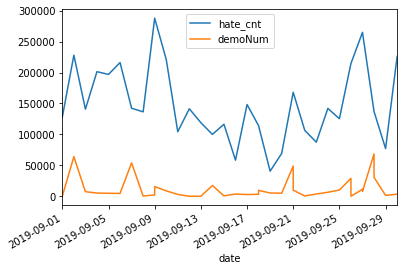

In [4]:
import matplotlib.pyplot as plt
F=pd.merge(X1,Y1,on='date')
F = F.set_index('date')
F.plot()


테스트로 9월 한 달을 그래프에 그려보니 어느정도 두 데이터가 비례하는 것 같아 보였다.

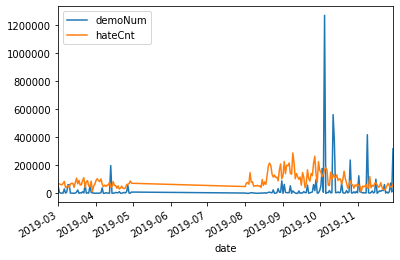

In [5]:
import matplotlib.pyplot as plt

total = pd.read_csv('total.csv')
total['date'] = total['date'].astype('str')
total['date'] = pd.to_datetime(total['date'], errors='coerce', format = "%Y%m%d")
total = total.set_index('date')

total.plot()


하지만 전체 기간으로 다시 그려보니 데이터가 분명하지 않아 보였다. 살펴보니 몇 가지 문제가 있었는데
우선 주말과 평일 같은 경우 "화나요" 수는 관계가 없지만 집회 참여 인원에는 많은 영향을 줬다.
또한 "화나요"의 상승세 혹은 하락세는 완만한 반면 시위 같은 경우 특정한 날 결집되고 그후 2, 3일 간은
참여자 수가 극감하는 양상을 보였다. 1대 1로 두 값을 매칭하는 것이 아닌 어느정도로 그룹화해서 매칭할 필요가 있음을 느꼈다.



In [6]:
demoNumColumnList = total.demoNum.tolist()


demoNumWeekList = [0]*(len(demoNumColumnList)//7) #합이 들어갈 메모리 공간 생성

for i in range(len(demoNumColumnList)-len(demoNumColumnList)%7): #꼬리 죄하고 반복 시작
    idx = i//7
    demoNumWeekList[idx] = demoNumWeekList[idx] + demoNumColumnList[i]

hateColumnList = total.hateCnt.tolist()
hateWeekList = [0]*(len(hateColumnList)//7) #합이 들어갈 메모리 공간 생성

for i in range(len(hateColumnList)-len(hateColumnList)%7): #꼬리 죄하고 반복 시작
    idx = i//7
    hateWeekList[idx] = hateWeekList[idx] + hateColumnList[i]



,demoNum,hateCnt
weeks,,
week 0,94104,457794
week 1,139120,399583
week 2,54900,557057
week 3,135356,516290
week 4,12357,503542
week 5,52780,443634
week 6,214500,406446
week 7,32140,282977
week 8,85470,479778


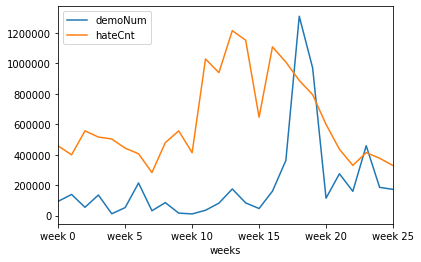

In [7]:
totalList = []

for i in range(len(demoNumWeekList)):
    totalList.append({'weeks': 'week '+str(i), 'demoNum':demoNumWeekList[i], "hateCnt":hateWeekList[i]})
totalDf = pd.DataFrame(totalList)
totalDf = totalDf.set_index('weeks')
totalDf.plot()
totalDf


일주일을 기준으로 합해서 다시 그래프에 그려봤다.
hateCnt와 demoNum가 단순히 비례할 뿐만 아니라 선후관계를 있는 것처럼 보였다.
이는 상식에도 부합하는 일이기도 했다(보통 정치적 이슈가 생기고 몇 주 뒤 시위를 참여할테니).
hateWeekList를 5주 정도 앞으로 당겨서 다시 한 번 비교해봤다.

In [8]:
hateWeekList = hateWeekList[:len(hateWeekList)-5]
for i in range(len(demoNumWeekList)-5):
    try:
        demoNumWeekList[i] = demoNumWeekList[i+5] 
    except:
        pass
demoNumWeekList = demoNumWeekList[:len(demoNumWeekList)-5]


In [9]:
#test code

print(len(demoNumWeekList) == len(hateWeekList))
print(demoNumWeekList)
print(hateWeekList)

True
[52780, 214500, 32140, 85470, 16500, 11327, 35350, 81980, 175150, 83570, 46920, 160820, 362560, 1309920, 969880, 114710, 275220, 159650, 459210, 185760, 172570]
[457794, 399583, 557057, 516290, 503542, 443634, 406446, 282977, 479778, 556826, 413675, 1029045, 939507, 1215138, 1152349, 646678, 1108807, 1008853, 887928, 794582, 599280]


,demoNum,hateCnt
weeks,,
week 0,52780,457794
week 1,214500,399583
week 2,32140,557057
week 3,85470,516290
week 4,16500,503542
week 5,11327,443634
week 6,35350,406446
week 7,81980,282977
week 8,175150,479778


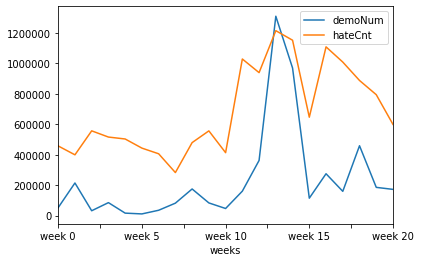

In [10]:
totalList = []

for i in range(len(demoNumWeekList)):
    totalList.append({'weeks': 'week '+str(i), 'demoNum':demoNumWeekList[i], "hateCnt":hateWeekList[i]})
totalDf = pd.DataFrame(totalList)
totalDf = totalDf.set_index('weeks')
totalDf.plot()
totalDf


두 변수가 어느정도 상관관계를 가지는 것으로 보인다.

# 5. 분석 결과 도출

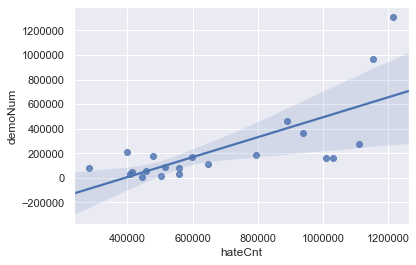

In [11]:
import  seaborn as sns
sns.set()
sns.regplot(data = totalDf, x='hateCnt', y = 'demoNum')

산포도에 좌표를 찍고 선을 그어봤다. SSE가 적어보이지만, 곡선의 패턴을 보이는 것은 아쉽다. 데이터가 더 많았으면  더 명확했을텐데 아쉬웠다.

In [12]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols(formula = 'demoNum ~ hateCnt', data = totalDf)
result = model.fit()
result.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                demoNum   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     20.56
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           0.000227
Time:                        06:12:01   Log-Likelihood:                -288.12
No. Observations:                  21   AIC:                             580.2
Df Residuals:                      19   BIC:                             582.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.181e+05   1.33e+05     -2.397      0.027   -5.96e+05   -4.03e+04
hateCnt        0.8115      0.179      4.534      0.000       0.437       1.186
==============================================================================
Omnibus:                        7.619   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                5.230
Skew:                           0.915   Prob(JB):                       0.0732
Kurtosis:                       4.622   Cond. No.                     1.95e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

위 표는 회귀분석 결과를 보여준다.
R-squared 값이 0.52로 이 모델은 52%의 양호한 설명력을 가졌다. 
F값이 20.56, p-value 는 0.00으로 통계적으로 유의한 모델임을 알 수 있다.
기울기는 0.8로 측정됐으며 p-value가 0이므로 유의한 직선이다.
따라서 주어진 데이터 내에서 두 변수가 분명한 관계를 가졌다(기울기 != 0) 결론내릴 수 있다.

0 	 36021626000000.0 	 [-7.67328] 	 [1.2370001e-06]
Tensor("Mean_2:0", shape=(), dtype=float32)


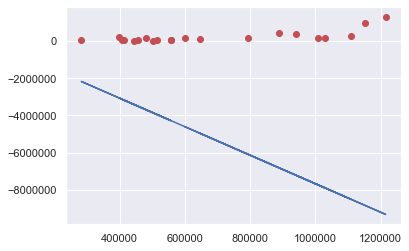

500 	 63014076000.0 	 [0.41472954] 	 [6.726085e-06]
Tensor("Mean_2:0", shape=(), dtype=float32)


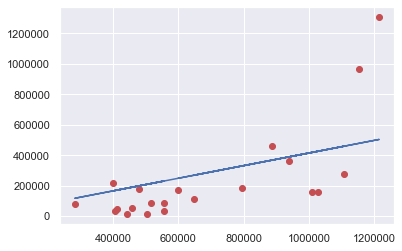

1000 	 63014076000.0 	 [0.41472954] 	 [2.1260462e-06]
Tensor("Mean_2:0", shape=(), dtype=float32)


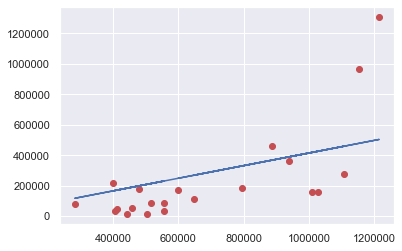

1500 	 63014076000.0 	 [0.41472954] 	 [-2.4740636e-06]
Tensor("Mean_2:0", shape=(), dtype=float32)


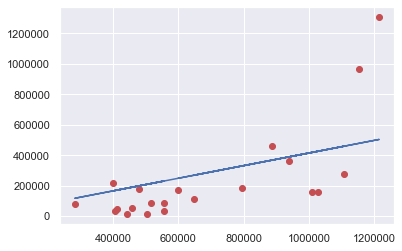

2000 	 63014076000.0 	 [0.41472954] 	 [-7.0740934e-06]
Tensor("Mean_2:0", shape=(), dtype=float32)


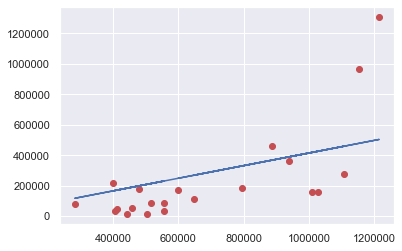

2500 	 63014076000.0 	 [0.41472954] 	 [-1.167429e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


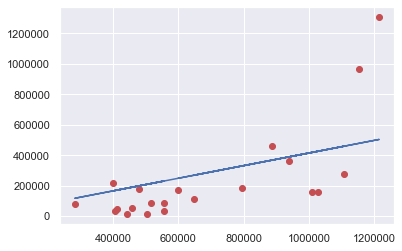

3000 	 63014076000.0 	 [0.41472954] 	 [-1.6274515e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


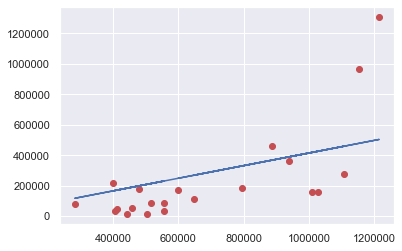

3500 	 63014076000.0 	 [0.41472954] 	 [-2.0874739e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


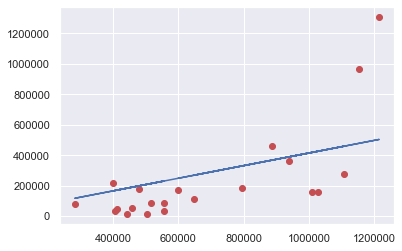

4000 	 63014076000.0 	 [0.41472954] 	 [-2.5474963e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


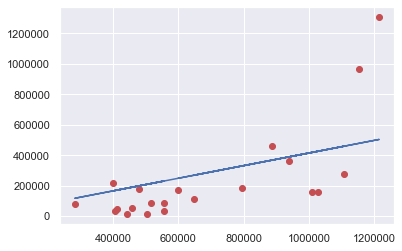

4500 	 63014076000.0 	 [0.41472954] 	 [-3.0075187e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


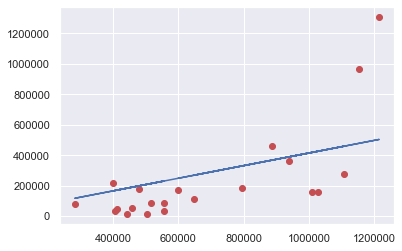

5000 	 63014076000.0 	 [0.41472954] 	 [-3.467541e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


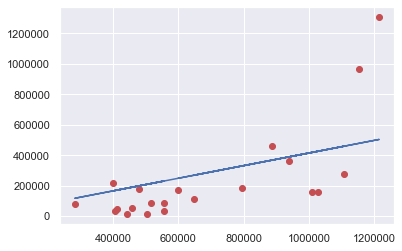

5500 	 63014076000.0 	 [0.41472954] 	 [-3.9275634e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


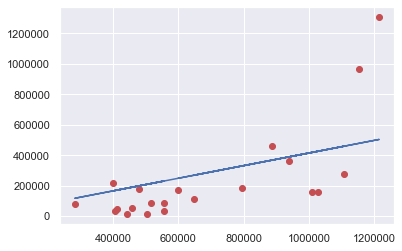

6000 	 63014076000.0 	 [0.41472954] 	 [-4.3875858e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


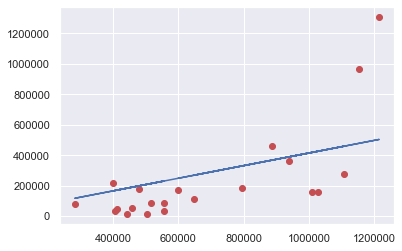

6500 	 63014076000.0 	 [0.41472954] 	 [-4.8476082e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


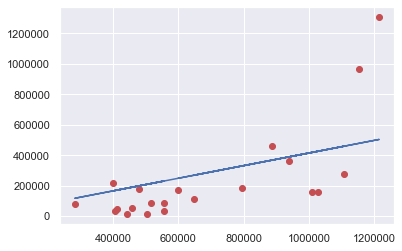

7000 	 63014076000.0 	 [0.41472954] 	 [-5.3076306e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


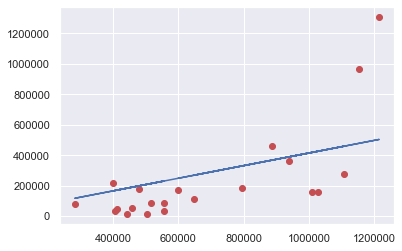

7500 	 63014076000.0 	 [0.41472954] 	 [-5.767653e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


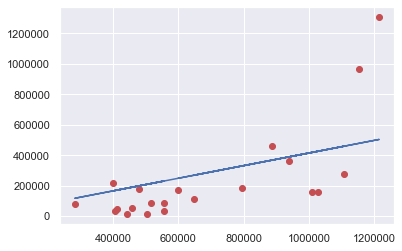

8000 	 63014076000.0 	 [0.41472954] 	 [-6.227627e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


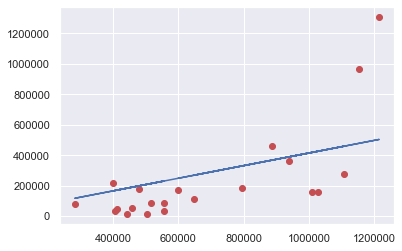

8500 	 63014076000.0 	 [0.41472954] 	 [-6.687467e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


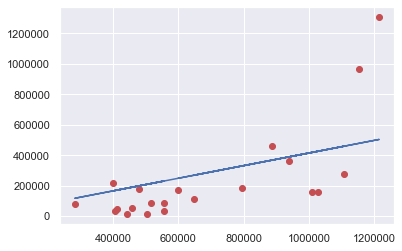

9000 	 63014076000.0 	 [0.41472954] 	 [-7.147308e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


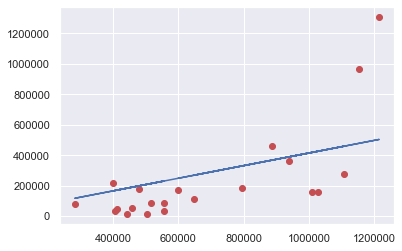

9500 	 63014076000.0 	 [0.41472954] 	 [-7.607148e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


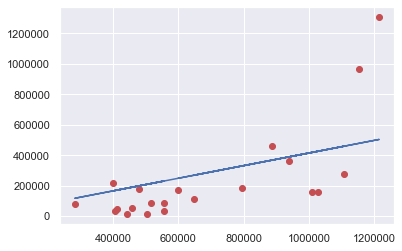

10000 	 63014076000.0 	 [0.41472954] 	 [-8.066989e-05]
Tensor("Mean_2:0", shape=(), dtype=float32)


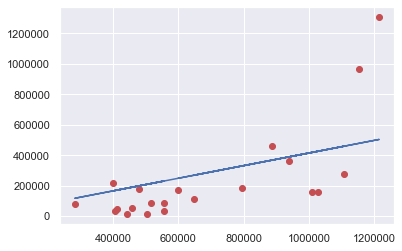

In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

model = tf.global_variables_initializer();



xy = np.array(totalDf, dtype=np.float32)

xData = xy[:, 1:] #독립 변수
yData = xy[:, [0]] #종속 변수


X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)


#난수
W = tf.Variable(tf.random.uniform([1], -10, 10))
b = tf.Variable(tf.zeros([1]))

#가설
hypothesis = W*X + b


#mse 설정! 

cost = tf.reduce_mean(tf.square(hypothesis - Y))



#최적화

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000000000001)

train = optimizer.minimize(cost)



sess = tf.Session()

sess.run(tf.global_variables_initializer())



# 학습 시작

for step in range(10001):
    sess.run(train, feed_dict={X:xData, Y:yData}) #먹이 주기
    if step%500 == 0:
        print(step,'\t', sess.run(cost,feed_dict={X:xData, Y:yData}),'\t', sess.run(W), '\t', sess.run(b))
        print(cost)
        plt.plot(xData,yData,'ro')
        plt.plot(xData,sess.run(W)*xData+sess.run(b))
        plt.show()
        

tensorflow로 머신러닝해봤다. 결과는 좋지 않다.
비용 함수가 줄어들지 않았다. 또한 직선의 기울기가 앞서 수행한 값과 차이가 있다. 
학습할 수 있는 표본의 수가 부족하기 때문인 것으로 보인다.

# 6. 결론
분석 결과 종속 변수인 "집회 신고 인원 수"는 독립 변수인 "네이버 정치 뉴스 싫어요"와 유의미한 관계가 있어보인다.
두 변수 간 선후 관계가 있어보이며 선의 설명력도 높은 편이다.
물론 데이터의 수가 현저히 모자라기 때문에 범위 밖의 데이터를 정확히 예측하기에는 부족하다.
충분한 양을 학습시킨다면 머신러닝을 통해 원하는 주차의 집회 규모를 예측할 수도 있을 것이다.

예측 같은 경우, 날씨 데이터 또한 활용해서 다변수 회귀분석을 적용한다면 더 좋은 결과가 있을 것으로 보인다.